In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as patches
import pandas_profiling
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from time import time

playlist = pd.read_csv('../input/nfl-playing-surface-analytics/PlayList.csv')
injuries = pd.read_csv('/kaggle/input/nfl-playing-surface-analytics/InjuryRecord.csv')
tracking = pd.read_csv('/kaggle/input/nfl-playing-surface-analytics/PlayerTrackData.csv')

# NFL Injury Analysis

The goal of this analysis is to understand player injuries based on specific variables related to plays and game conditions.

In [2]:
playlist.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [3]:
injuries.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


# Synthetic vs Natural Data Split

In [4]:
inj_natural = injuries[injuries.Surface == 'Natural']
inj_turf = injuries[injuries.Surface == 'Synthetic']

In [5]:
inj_natural.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
5,41145,41145-2,41145-2-60,Knee,Natural,1,0,0,0
7,44860,44860-5,44860-5-52,Knee,Natural,1,1,0,0
11,36621,36621-13,36621-13-58,Foot,Natural,1,1,1,1


In [6]:
inj_turf.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1
6,46014,46014-10,46014-10-22,Ankle,Synthetic,1,1,1,1
8,44806,44806-7,44806-7-61,Knee,Synthetic,1,0,0,0


* Visualize the field
* Heatmaps of different types of injuries
* Heatmap with player position on days missed on synthetic vs real turf
* trends when connecting player injuries to he attributes of the play
* Ultimately have to connect it to a surface factor
* Build a logistic model that predicts probability of injury based on surface type
* How early in the game do they get injured based on the surface
* number of plays it takes for an injury based on position
* number of days missed based on injury

# Data cleaning

In [7]:
inj_nat_play = pd.merge(inj_natural,
                 playlist,
                 on=['PlayerKey', 'GameID', 'PlayKey'],
                       how='left')
inj_tur_play = pd.merge(inj_turf,
                 playlist,
                 on=['PlayerKey', 'GameID', 'PlayKey'],
                       how ='left')

inj_play = pd.merge(injuries,
                 playlist,
                 on=['PlayerKey', 'GameID', 'PlayKey'],
                       how ='left')

inj_play_enc = pd.concat([inj_play,pd.get_dummies(inj_play['BodyPart'], prefix='part'), pd.get_dummies(inj_play['RosterPosition'], prefix='pos')],axis=1)

inj_play.head()


#put NAN play key into separate file then join with attributes

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,Linebacker,29.0,4.0,Indoors,Synthetic,84.0,Cloudy,Punt,32.0,OLB,LB
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,Linebacker,50.0,7.0,Open,Natural,76.0,Partly Cloudy,Punt,26.0,OLB,LB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1.0,1.0,Outdoor,Synthetic,63.0,Clear and warm,Pass,70.0,SS,DB
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,Linebacker,15.0,3.0,Outdoor,Natural,80.0,Cloudy,Punt,30.0,LB,LB
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,Wide Receiver,32.0,5.0,Retractable Roof,Synthetic,89.0,Partly Cloudy,Kickoff,69.0,WR,WR


In [8]:
injuries['DM_M1'].value_counts()

1    105
Name: DM_M1, dtype: int64

In [9]:
injuries['DM_M7'].value_counts()

1    76
0    29
Name: DM_M7, dtype: int64

In [10]:
injuries['DM_M28'].value_counts()

0    68
1    37
Name: DM_M28, dtype: int64

In [11]:
injuries['DM_M42'].value_counts()

0    76
1    29
Name: DM_M42, dtype: int64

In [12]:
playlist['StadiumType'].value_counts()

Outdoor                   145032
Outdoors                   32956
Indoors                    22805
Dome                        9376
Retractable Roof            8914
Indoor                      6892
Open                        4124
Domed, closed               3076
Retr. Roof - Closed         2235
Retr. Roof-Closed           2015
Domed, open                 1779
Dome, closed                1059
Closed Dome                 1011
Domed                        985
Oudoor                       914
Domed, Open                  807
Ourdoor                      778
Outdoor Retr Roof-Open       601
Outddors                     595
Indoor, Roof Closed          547
Retr. Roof-Open              486
Retr. Roof - Open            486
Indoor, Open Roof            479
Bowl                         465
Retr. Roof Closed            414
Heinz Field                  389
Outdor                       356
Outside                      341
Cloudy                       178
Name: StadiumType, dtype: int64

In [13]:
playlist['Weather'].value_counts()

Cloudy                                                                              60705
Sunny                                                                               51728
Partly Cloudy                                                                       28463
Clear                                                                               25923
Mostly Cloudy                                                                       11176
                                                                                    ...  
30% Chance of Rain                                                                    354
Partly Clouidy                                                                        302
Coudy                                                                                 278
Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.      246
Party Cloudy                                                                          230
Name: Weat

In [14]:
m_inju_play=pd.merge(playlist,injuries,on='PlayKey',how='left')
m_inju_play['Injury'] = m_inju_play['BodyPart'].apply(lambda x: 1 if x in ['Knee','Foot','Ankle']  else 0)

m_inju_play_agg=m_inju_play[['StadiumType','FieldType','Weather','Injury', 'PlayType', 'Position', 'PlayerDay', 'Temperature']]
#Change weather to 1 and 0
m_inju_play_agg['Weather']=m_inju_play_agg.Weather.isin(['rain','Rain','Snow','snow'])
m_inju_play_agg['Weather'] = m_inju_play_agg['Weather'].apply(lambda x: 1 if x== True  else 0)

m_inju_play_agg['StadiumType']=m_inju_play_agg.StadiumType.isin(['Outdoor','Oudoor','Open','Ourdoor','Out','open'])
m_inju_play_agg['StadiumType'] = m_inju_play_agg['StadiumType'].apply(lambda x: 1 if x== True  else 0)

m_inju_play_agg['FieldType']=m_inju_play_agg.FieldType.isin(['Natural'])
m_inju_play_agg['FieldType'] = m_inju_play_agg['FieldType'].apply(lambda x: 1 if x== True  else 0)

m_inju_play_agg.PlayType = pd.Categorical(m_inju_play_agg.PlayType)
m_inju_play_agg['PlayType_c'] = m_inju_play_agg.PlayType.cat.codes

m_inju_play_agg.Position = pd.Categorical(m_inju_play_agg.Position)
m_inju_play_agg['Position_c'] = m_inju_play_agg.Position.cat.codes

#Now we are going to multiplicate the StadiumType Variable with the Weather because the weather doesnt matter if the match is played on a closed stadium

m_inju_play_agg['Multiplication']=m_inju_play_agg['StadiumType']*m_inju_play_agg['Weather']

In [15]:
m_inju_play_agg.head()

,StadiumType,FieldType,Weather,Injury,PlayType,Position,PlayerDay,Temperature,PlayType_c,Position_c,Multiplication
0,1,0,0,0,Pass,QB,1,63,6,16,0
1,1,0,0,0,Pass,QB,1,63,6,16,0
2,1,0,0,0,Rush,QB,1,63,10,16,0
3,1,0,0,0,Rush,QB,1,63,10,16,0
4,1,0,0,0,Pass,QB,1,63,6,16,0


# EDA

# Body Part

<AxesSubplot:xlabel='BodyPart', ylabel='count'>

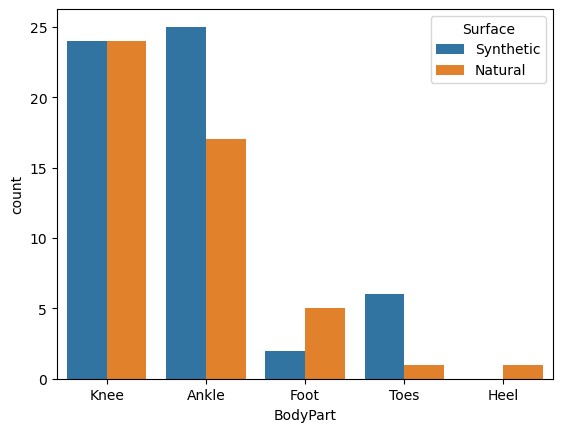

In [16]:
sns.countplot(data = inj_play, x='BodyPart', hue = 'Surface')

# Roster Position

<AxesSubplot:xlabel='RosterPosition', ylabel='count'>

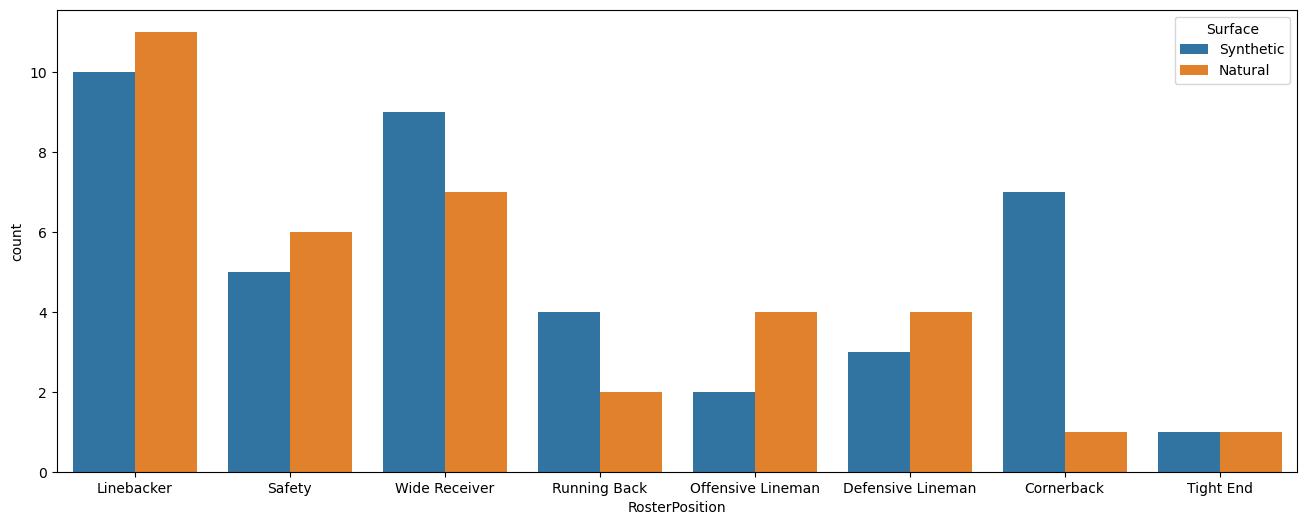

In [17]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='RosterPosition', hue='Surface')

<AxesSubplot:xlabel='PositionGroup', ylabel='count'>

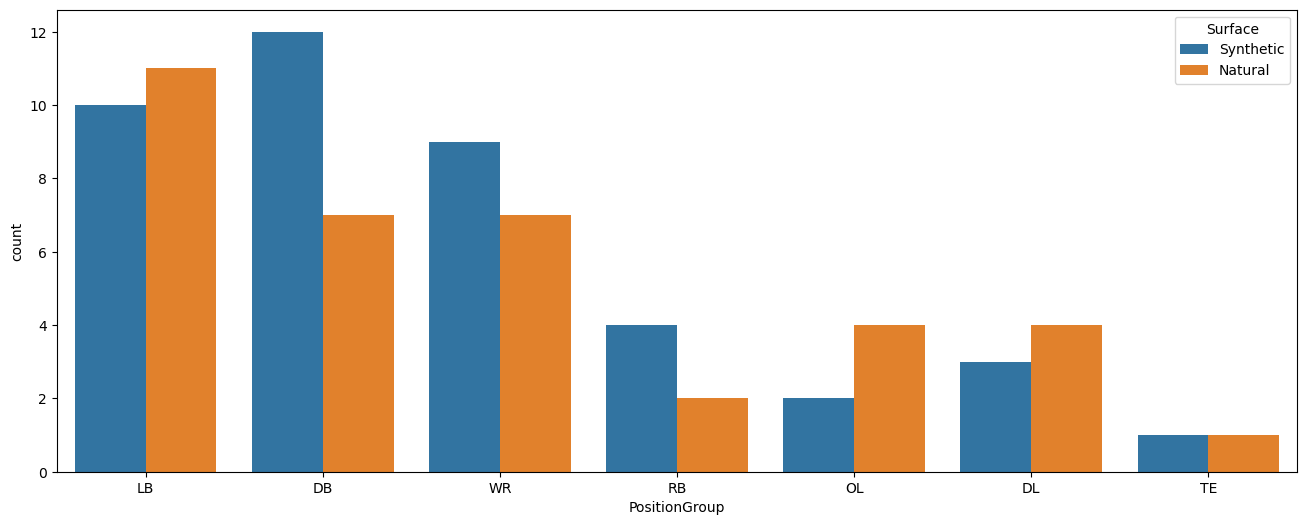

In [18]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='PositionGroup', hue='Surface')

<AxesSubplot:xlabel='PlayType', ylabel='count'>

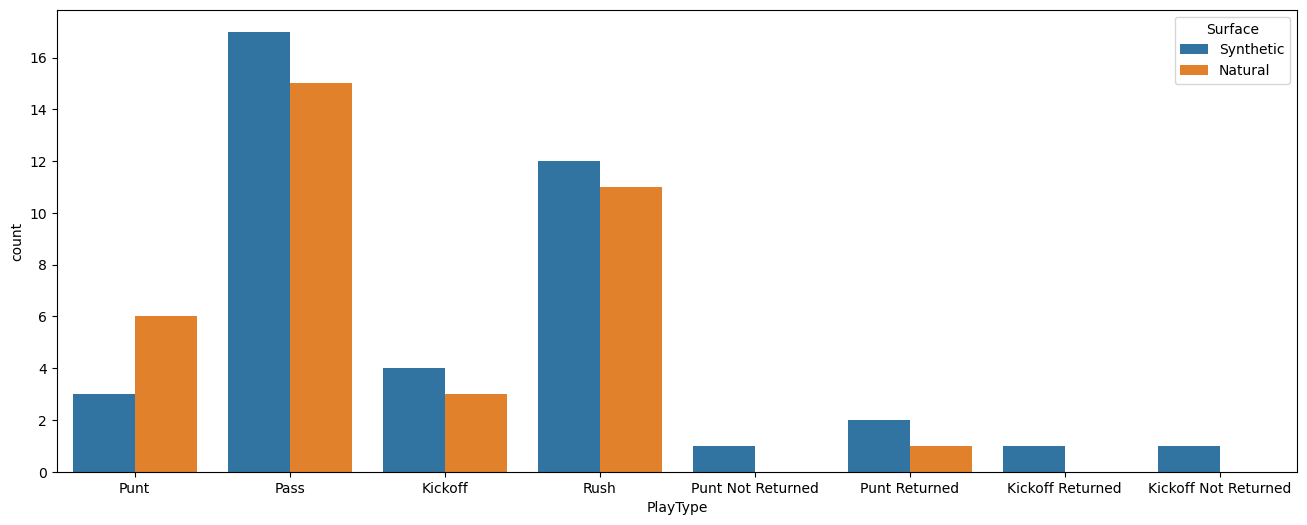

In [19]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='PlayType', hue='Surface')

<AxesSubplot:xlabel='DM_M7', ylabel='count'>

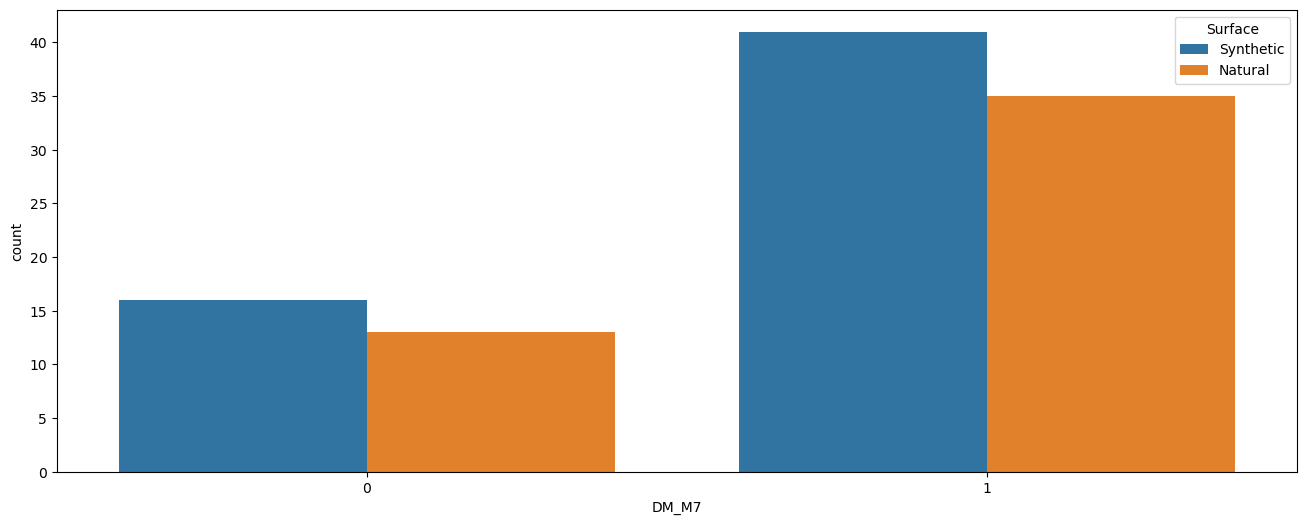

In [20]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='DM_M7', hue='Surface')

<AxesSubplot:xlabel='DM_M28', ylabel='count'>

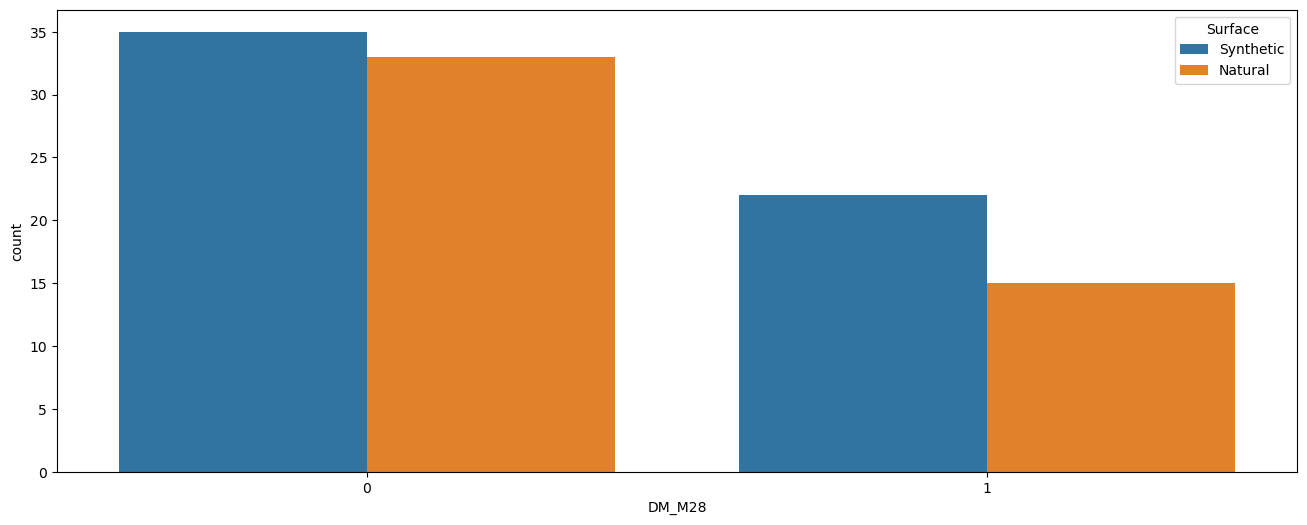

In [21]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='DM_M28', hue='Surface')

<AxesSubplot:xlabel='DM_M42', ylabel='count'>

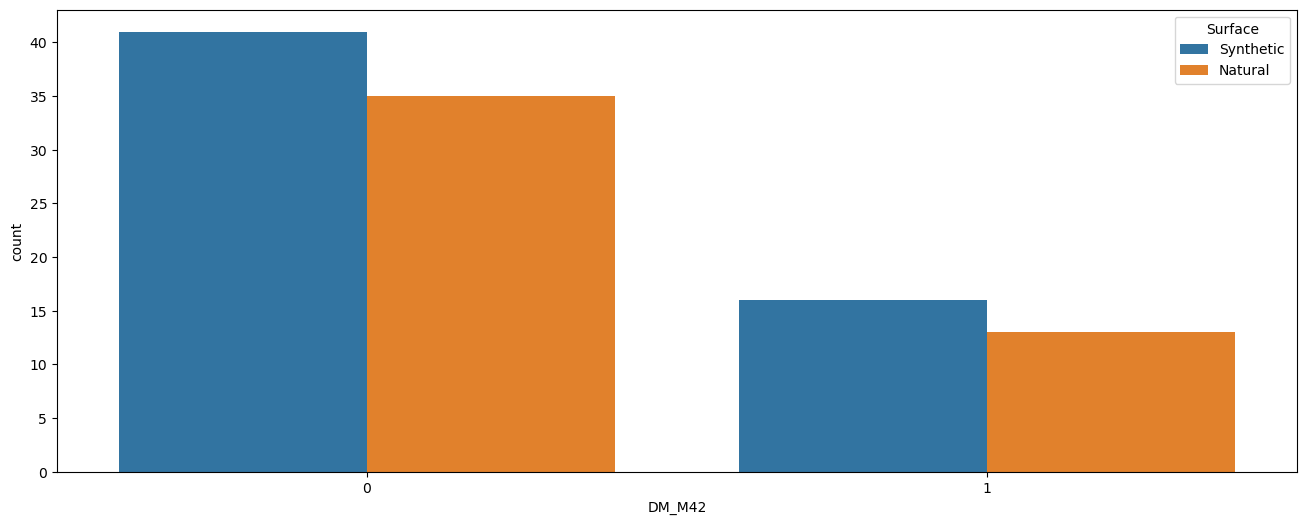

In [22]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='DM_M42', hue='Surface')

<AxesSubplot:xlabel='Weather', ylabel='count'>

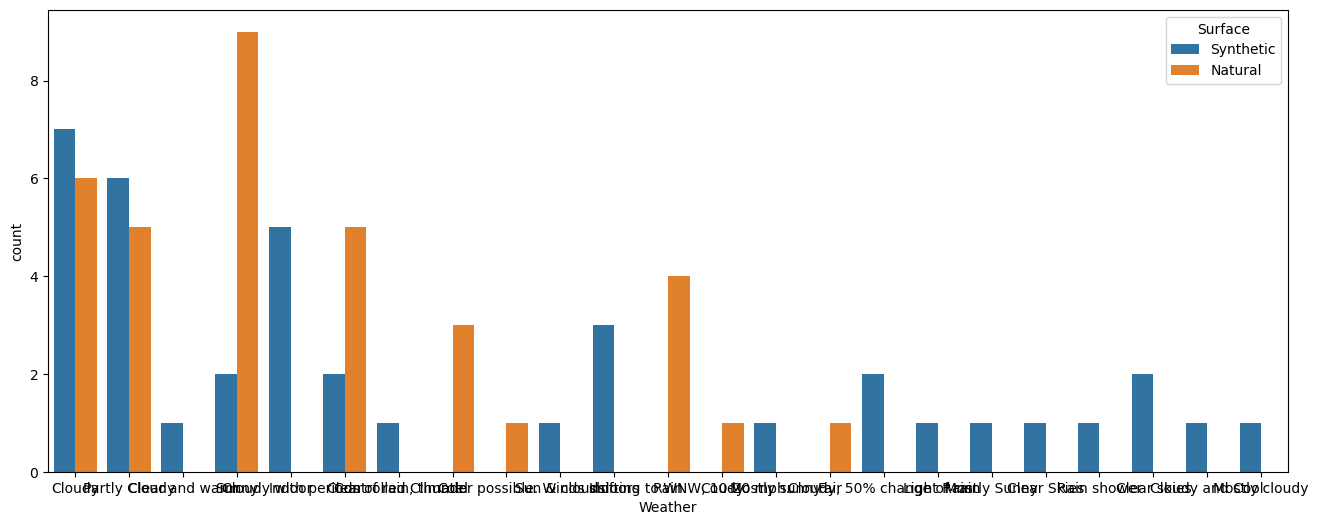

In [23]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='Weather', hue='Surface')

<AxesSubplot:xlabel='StadiumType', ylabel='count'>

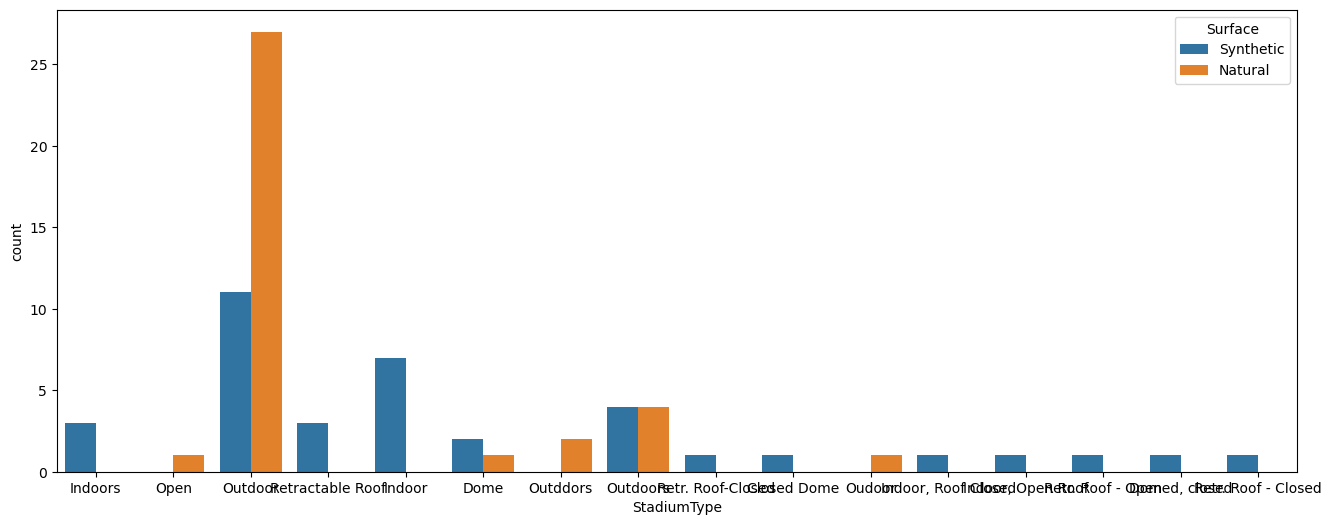

In [24]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='StadiumType', hue = 'Surface')

Are there certain stadiums where they are occurng more than others?

What body parts are being injured by position? and by surface?

<AxesSubplot:xlabel='PositionGroup', ylabel='count'>

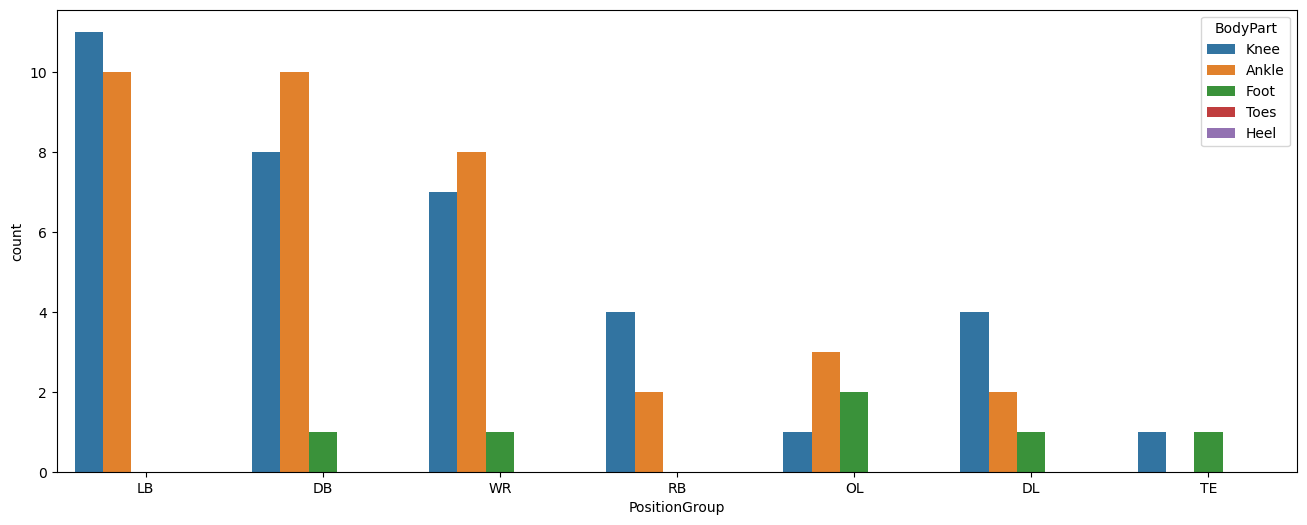

In [25]:
plt.figure(figsize=(16,6))
sns.countplot(data=inj_play, x='PositionGroup', hue='BodyPart')

In [26]:
inj_play[inj_play['BodyPart']=='Toes']

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
49,45950,45950-6,NaN,Toes,Synthetic,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,38253,38253-10,NaN,Toes,Synthetic,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,38214,38214-12,NaN,Toes,Synthetic,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,47196,47196-7,NaN,Toes,Synthetic,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,45975,45975-23,NaN,Toes,Natural,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,47273,47273-10,NaN,Toes,Synthetic,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,40405,40405-29,NaN,Toes,Synthetic,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
injuries[injuries['BodyPart']=='Toes']

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
49,45950,45950-6,NaN,Toes,Synthetic,1,1,0,0
51,38253,38253-10,NaN,Toes,Synthetic,1,1,1,0
52,38214,38214-12,NaN,Toes,Synthetic,1,0,0,0
96,47196,47196-7,NaN,Toes,Synthetic,1,1,0,0
97,45975,45975-23,NaN,Toes,Natural,1,1,0,0
98,47273,47273-10,NaN,Toes,Synthetic,1,0,0,0
99,40405,40405-29,NaN,Toes,Synthetic,1,1,0,0
